In [2]:
import math
import random
import json
from collections import defaultdict
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt


In [3]:
def load_data(json_file):
    """
    Load the dataset from the given JSON file.
    Each sentence is a list of (word, tag) tuples.
    """
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    sentences = []
    for sentence, tags in data:
        sentence_tokens = sentence.split()
        sentence_with_tags = list(zip(sentence_tokens, tags))
        sentences.append(sentence_with_tags)
    return sentences
sentences=load_data('penn-data.json')
sentences[0]

[('Pierre', 'NNP'),
 ('Vinken,', 'NNP'),
 ('61', 'CD'),
 ('years', 'NNS'),
 ('old,', 'JJ'),
 ('will', 'MD'),
 ('join', 'VB'),
 ('the', 'DT'),
 ('board', 'NN'),
 ('as', 'IN'),
 ('a', 'DT'),
 ('nonexecutive', 'JJ'),
 ('director', 'NN'),
 ('Nov.', 'NNP'),
 ('29.', 'CD')]

In [4]:
def split_data(sentences, test_ratio=0.2):
    """
    Split the dataset into training and testing sets.
    """
    random.shuffle(sentences)
    split_idx = int(len(sentences) * (1 - test_ratio))
    return sentences[:split_idx], sentences[split_idx:]

In [5]:
def map_to_4tags(tag):
    """Collapse 36 tags into 4 categories: N, V, A, O."""
    if tag.startswith('N'):  # Nouns
        return 'N'
    elif tag.startswith('V'):  # Verbs
        return 'V'
    elif tag.startswith('JJ') or tag.startswith('RB'):  # Adjectives/Adverbs
        return 'A'
    else:  # Other
        return 'O'

def preprocess_4tag(sentences):
    """Convert 36-tag sentences to 4-tag sentences."""
    return [[(word, map_to_4tags(tag)) for (word, tag) in sentence] for sentence in sentences]

In [6]:
def train_model_a(train_sentences):
    """Train First-Order HMM with add-one smoothing."""
    transition_counts = defaultdict(lambda: defaultdict(int))
    initial_counts = defaultdict(int)
    emission_counts = defaultdict(lambda: defaultdict(int))
    tag_counts = defaultdict(int)
    all_tags = set()
    all_words = set()

    for sentence in train_sentences:
        prev_tag = None
        for i, (word, tag) in enumerate(sentence):
            all_tags.add(tag)
            all_words.add(word)
            tag_counts[tag] += 1
            emission_counts[tag][word] += 1
            if i == 0:
                initial_counts[tag] += 1
            else:
                transition_counts[prev_tag][tag] += 1
            prev_tag = tag

    # Add-one smoothing for initial probabilities
    num_tags = len(all_tags)
    initial_probs = defaultdict(lambda: -math.inf)
    total_initial = sum(initial_counts.values()) + num_tags
    for tag in all_tags:
        count = initial_counts.get(tag, 0) + 1
        initial_probs[tag] = math.log(count / total_initial)

    # Add-one smoothing for transition probabilities
    transition_probs = defaultdict(lambda: defaultdict(lambda: -math.inf))
    for prev_tag in all_tags:
        total = sum(transition_counts[prev_tag].values()) + num_tags
        for curr_tag in all_tags:
            count = transition_counts[prev_tag].get(curr_tag, 0) + 1
            transition_probs[prev_tag][curr_tag] = math.log(count / total)

    # Add-one smoothing for emission probabilities
    num_words = len(all_words)
    emission_probs = defaultdict(lambda: defaultdict(lambda: -math.inf))
    for tag in all_tags:
        total_emissions = tag_counts[tag] + num_words + 1
        for word in all_words:
            count = emission_counts[tag].get(word, 0) + 1
            emission_probs[tag][word] = math.log(count / total_emissions)
        emission_probs[tag]['UNK'] = math.log(1 / total_emissions)  # For unseen words

    # Most frequent tag for unseen words
    most_freq_tag = max(tag_counts, key=lambda k: tag_counts[k])
    return initial_probs, transition_probs, emission_probs, most_freq_tag, all_tags, all_words

In [7]:
def viterbi_a(sentence, initial_probs, transition_probs, emission_probs, most_freq_tag, all_tags, all_words):
    """Predict the best tag sequence using the Viterbi algorithm."""
    words = [word for word, _ in sentence]
    n = len(words)
    viterbi = [{}]
    backpointers = [{}]

    # Initialize first step
    for tag in all_tags:
        word = words[0]
        if word not in all_words:
            emit_prob = 0.0 if tag == most_freq_tag else -math.inf
        else:
            emit_prob = emission_probs[tag].get(word, emission_probs[tag]['UNK'])
        viterbi[0][tag] = initial_probs[tag] + emit_prob
        backpointers[0][tag] = None

    # Recursion
    for t in range(1, n):
        viterbi.append({})
        backpointers.append({})
        word = words[t]
        for curr_tag in all_tags:
            max_prob = -math.inf
            best_prev_tag = None
            if word not in all_words:
                emit_prob = 0.0 if curr_tag == most_freq_tag else -math.inf
            else:
                emit_prob = emission_probs[curr_tag].get(word, emission_probs[curr_tag]['UNK'])
            for prev_tag in all_tags:
                prob = viterbi[t-1].get(prev_tag, -math.inf) + transition_probs[prev_tag][curr_tag] + emit_prob
                if prob > max_prob:
                    max_prob = prob
                    best_prev_tag = prev_tag
            if best_prev_tag is not None:
                viterbi[t][curr_tag] = max_prob
                backpointers[t][curr_tag] = best_prev_tag

    # Backtracking
    best_path = []
    max_final = max(viterbi[-1].values(), default=-math.inf)
    best_tag = next((tag for tag, prob in viterbi[-1].items() if prob == max_final), None)
    if best_tag is None:
        return [most_freq_tag] * n
    best_path.append(best_tag)
    for t in reversed(range(1, n)):
        best_tag = backpointers[t][best_tag]
        best_path.insert(0, best_tag)
    return best_path


In [8]:
def evaluate(true_sentences, pred_sentences):
    """Compute overall and tag-wise accuracy."""
    total = correct = 0
    tag_correct = defaultdict(int)
    tag_total = defaultdict(int)
    for true, pred in zip(true_sentences, pred_sentences):
        for (_, true_tag), pred_tag in zip(true, pred):
            total += 1
            tag_total[true_tag] += 1
            if true_tag == pred_tag:
                correct += 1
                tag_correct[true_tag] += 1
    overall_acc = correct / total if total else 0
    tag_acc = {tag: tag_correct[tag]/tag_total[tag] for tag in tag_total}
    return overall_acc, tag_acc


In [9]:
json_file = 'penn-data.json'  # Replace with your JSON file path
sentences = load_data(json_file)
train_36, test_36 = split_data(sentences)
train_4 = preprocess_4tag(train_36)
test_4 = preprocess_4tag(test_36)

# Train and evaluate 36-tag model
initial_36, trans_36, emit_36, mft_36, tags_36, words_36 = train_model_a(train_36)
preds_36 = [viterbi_a(s, initial_36, trans_36, emit_36, mft_36, tags_36, words_36) for s in test_36]
acc_36, tag_acc_36 = evaluate(test_36, preds_36)

# Train and evaluate 4-tag model
initial_4, trans_4, emit_4, mft_4, tags_4, words_4 = train_model_a(train_4)
preds_4 = [viterbi_a(s, initial_4, trans_4, emit_4, mft_4, tags_4, words_4) for s in test_4]
acc_4, tag_acc_4 = evaluate(test_4, preds_4)

# Print results
print("=== 36-Tag Configuration ===")
print(f"Overall Accuracy: {acc_36:.4f}")
print("Tag-wise Accuracy (All 36 Tags):")

# List of all 36 Penn Treebank tags (sorted alphabetically)
all_36_tags = [
    '#', ':', 'CC', 'CD', 'DT', 'EX', 'IN', 
    'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 
    'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 
    'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB','HE'
]

# Print accuracy for all 36 tags (including those not in the test set)
for tag in sorted(all_36_tags):
    acc = tag_acc_36.get(tag, 0.0)  # Default to 0.0 if tag not in test set
    print(f"{tag}: {acc:.4f}")

print("\n=== 4-Tag Configuration ===")
print(f"Overall Accuracy: {acc_4:.4f}")
print("Tag-wise Accuracy:")
all_4_tags=['N', 'V', 'A', 'O']
for tag in all_4_tags:
    print(f"{tag}: {tag_acc_4.get(tag, 0.0):.4f}")

=== 36-Tag Configuration ===
Overall Accuracy: 0.7507
Tag-wise Accuracy (All 36 Tags):
#: 0.0000
:: 0.8036
CC: 0.9773
CD: 0.4618
DT: 0.9836
EX: 0.5385
HE: 0.0000
IN: 0.9706
JJ: 0.6485
JJR: 0.4231
JJS: 0.0857
LS: 0.0000
MD: 0.8804
NN: 0.9061
NNP: 0.5928
NNPS: 0.0000
NNS: 0.5835
PDT: 0.0000
PRP: 0.8423
PRP$: 0.9407
RB: 0.4379
RBR: 0.0952
RBS: 0.0000
RP: 0.1395
TO: 0.9930
UH: 0.0000
VB: 0.7480
VBD: 0.7473
VBG: 0.2140
VBN: 0.5270
VBP: 0.5950
VBZ: 0.7266
WDT: 0.6061
WP: 0.6444
WP$: 0.0000
WRB: 0.2444

=== 4-Tag Configuration ===
Overall Accuracy: 0.8416
Tag-wise Accuracy:
N: 0.7459
V: 0.7679
A: 0.6930
O: 0.9979


0.8403940886699507
{'A': 0.6013824884792627, 'O': 0.9194237771093874, 'N': 0.9003502626970228, 'V': 0.6681469519580138}


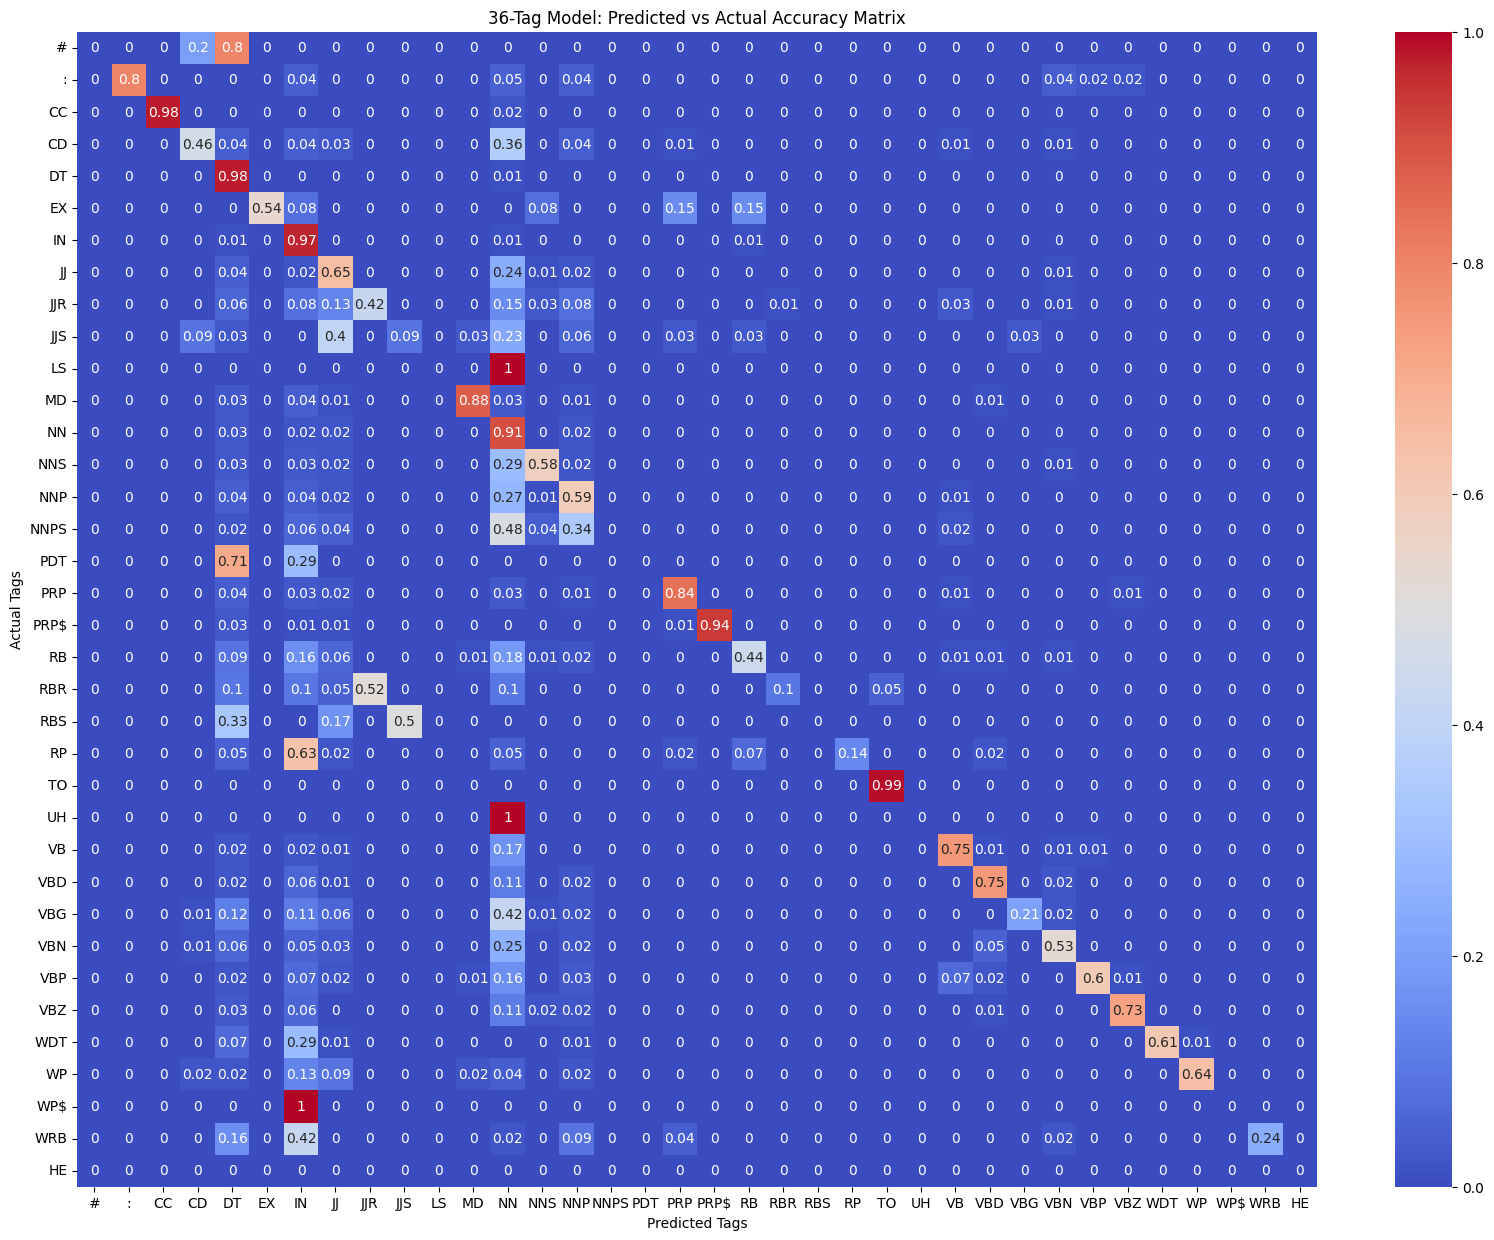

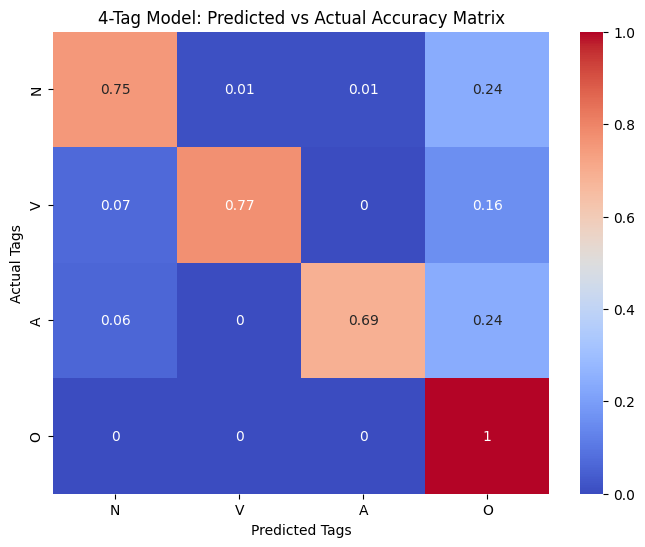

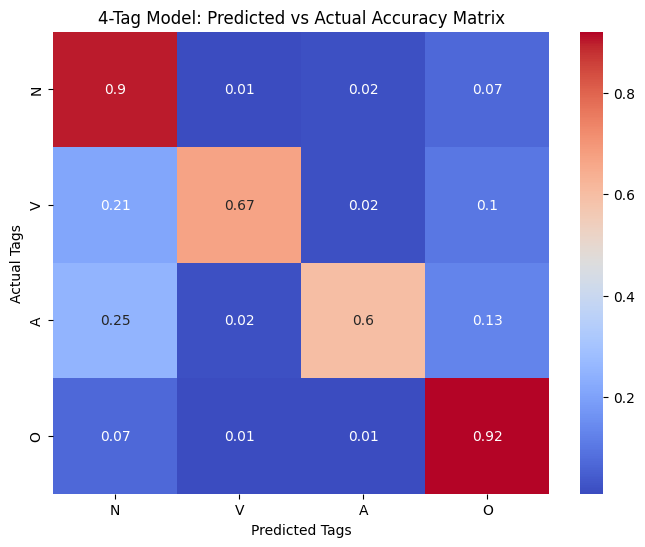

In [ ]:
all_36_tags = [
    '#', ':', 'CC', 'CD', 'DT', 'EX', 'IN', 
    'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 
    'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 
    'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB','HE'
]
all_4_tags=['N', 'V', 'A', 'O']

def create_accuracy_matrix(tags, actual_data, predicted_data):
    size = len(tags)
    matrix = np.zeros((size, size))
    
    tag_index = {tag: i for i, tag in enumerate(tags)}
    # Count occurrences and mismatches
    for actual_sentence, predicted_sentence in zip(actual_data, predicted_data):
        for actual_pair, predicted_tag in zip(actual_sentence, predicted_sentence):
            actual_tag = actual_pair[1]  # Assuming actual_pair is (word, tag)
            
            if actual_tag in tags and predicted_tag in tags:
                actual_index = tag_index[actual_tag]  # Get index for the actual tag
                predicted_index = tag_index[predicted_tag]  # Get index for the predicted tag
                matrix[actual_index][predicted_index] += 1  # Increment the count

    # Normalize the matrix rows to convert counts to probabilities if needed
    row_sums = matrix.sum(axis=1, keepdims=True)
    # Check for rows where the sum is zero to avoid division by zero
    matrix = np.divide(matrix, row_sums, where=row_sums!=0)
    matrix = np.around(matrix, decimals=2)   # Avoid division by zero automatically handles by numpy

    return matrix



# Generating matrices for 36-tag and 4-tag models
matrix_36 = create_accuracy_matrix(all_36_tags, test_36, preds_36)
matrix_4 = create_accuracy_matrix(all_4_tags, test_4, preds_4)
test_mapped = [[(i[0],map_to_4tags(i[1])) for i in sent ] for sent in test_36]
pred_mapped = [[map_to_4tags(i) for i in sent ] for sent in preds_36]
matrix_36_mapped_4 = create_accuracy_matrix(all_4_tags, test_mapped, pred_mapped)
acc_maped_4,acc_tag_maped_4=evaluate(test_mapped,pred_mapped)
print(acc_maped_4)
print(acc_tag_maped_4)
# 36-Tag Model Heatmap
plt.figure(figsize=(20, 15))  # Creates a new figure with specified size
sns.heatmap(matrix_36, annot=True, cmap='coolwarm', xticklabels=all_36_tags, yticklabels=all_36_tags)
plt.title('36-Tag Model: Predicted vs Actual Accuracy Matrix')
plt.xlabel('Predicted Tags')
plt.ylabel('Actual Tags')
plt.show()  # Display the first heatmap

# 4-Tag Model Heatmap
plt.figure(figsize=(8, 6))  # Creates another new figure with specified size
sns.heatmap(matrix_4, annot=True, cmap='coolwarm', xticklabels=all_4_tags, yticklabels=all_4_tags)
plt.title('4-Tag Model: Predicted vs Actual Accuracy Matrix')
plt.xlabel('Predicted Tags')
plt.ylabel('Actual Tags')
plt.show()  # Display the second heatmap

plt.figure(figsize=(8, 6))  # Creates another new figure with specified size
sns.heatmap(matrix_36_mapped_4, annot=True, cmap='coolwarm', xticklabels=all_4_tags, yticklabels=all_4_tags)
plt.title('36-Tag mapped to 4 Model: Predicted vs Actual Accuracy Matrix')
plt.xlabel('Predicted Tags')
plt.ylabel('Actual Tags')
plt.show()

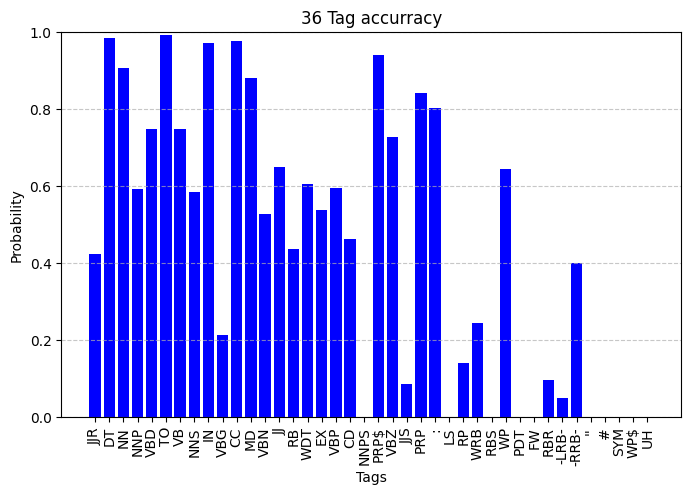

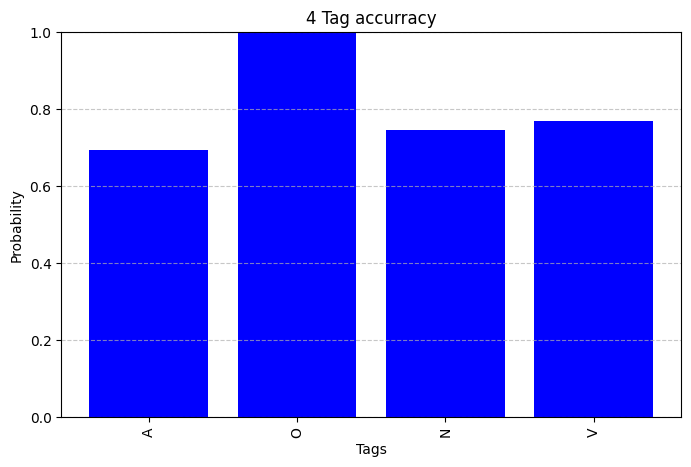

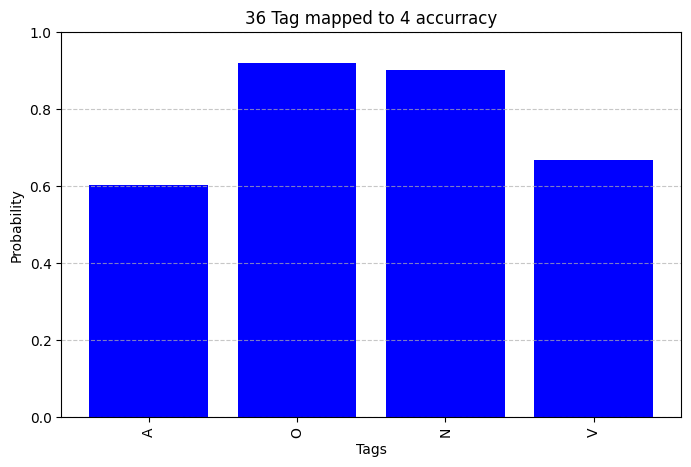

In [14]:
def plot_accuracy(data,name):
    plt.figure(figsize=(8, 5))
    plt.bar(data.keys(), data.values(), color='blue')
    plt.title(name)
    plt.xlabel('Tags')
    plt.ylabel('Probability')
    plt.xticks(rotation=90)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_accuracy(tag_acc_36,"36 Tag accurracy")
plot_accuracy(tag_acc_4,"4 Tag accurracy")
plot_accuracy(acc_tag_maped_4,"36 Tag mapped to 4 accurracy")